In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('hw_daily-temperatures.csv', index_col = ['date'], parse_dates=True)

In [3]:
df.head()

,temp
date,
1987-10-18,10.1
1987-10-19,11.3
1987-10-20,10.4
1987-10-21,10.9
1987-10-22,9.2


In [4]:
df.tail()

,temp
date,
1990-12-08,15.5
1990-12-09,14.1
1990-12-10,11.0
1990-12-11,11.1
1990-12-12,14.0


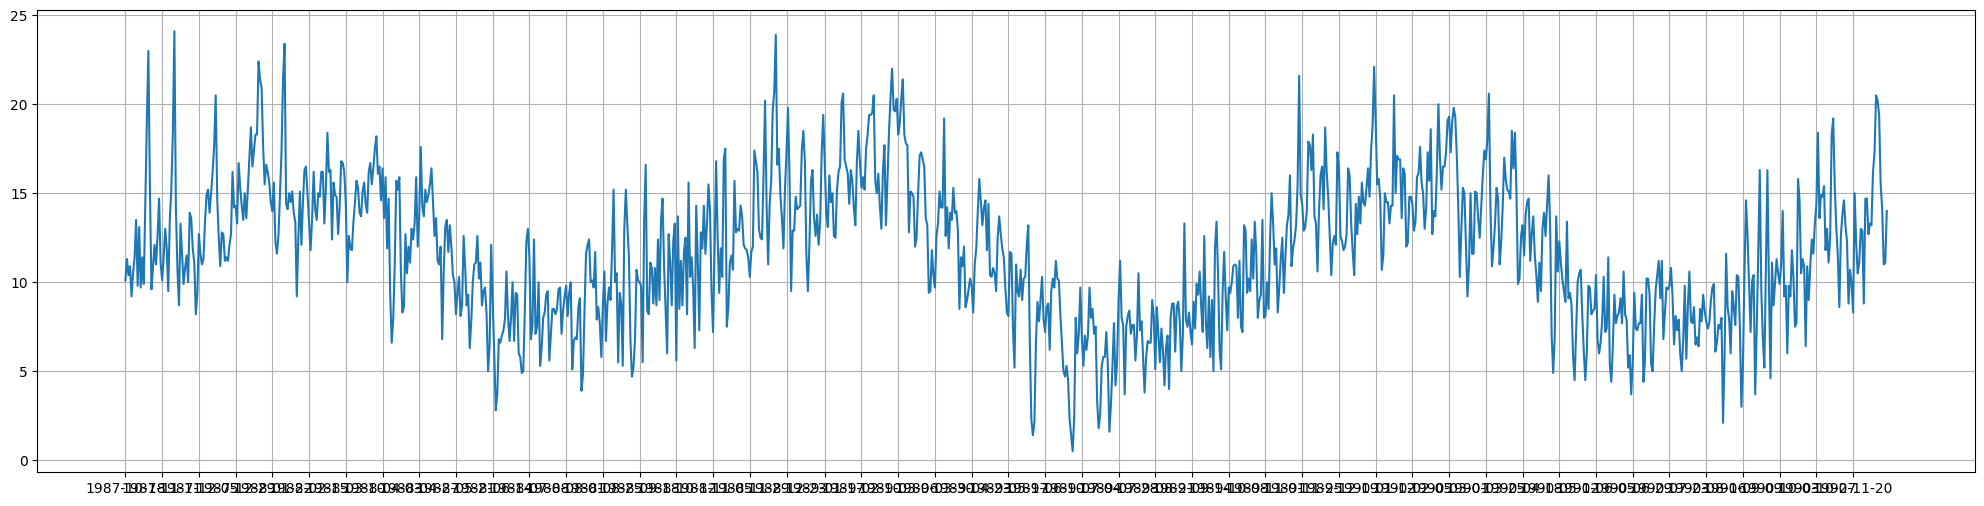

In [5]:
plt.figure(figsize=(25, 6))
plt.plot(df['temp'])
plt.xticks([df.index[i] for i in range(0, len(df), 24)])
plt.grid(True)
plt.show()

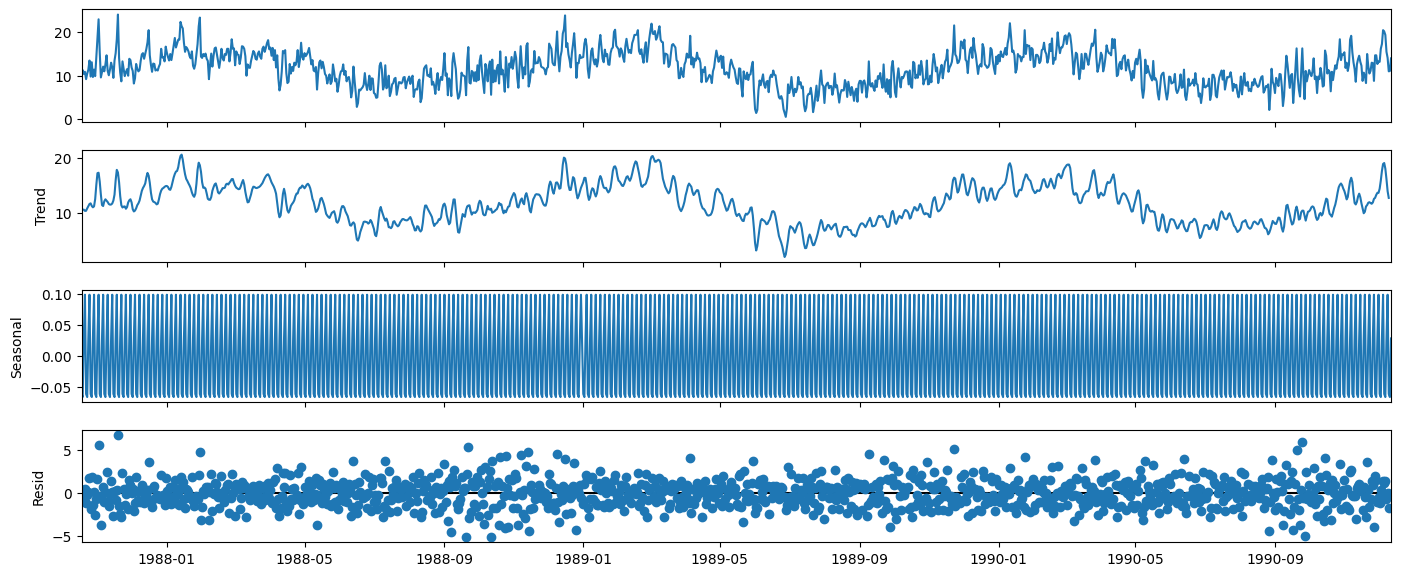

In [6]:
parts = seasonal_decompose(df, period=4)
fig = parts.plot()
fig.set_size_inches(15, 6)

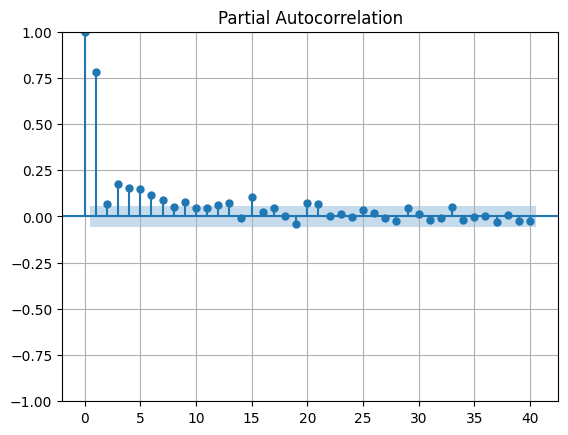

In [7]:
plot_pacf(df, lags=40)
plt.grid(True)
plt.show()

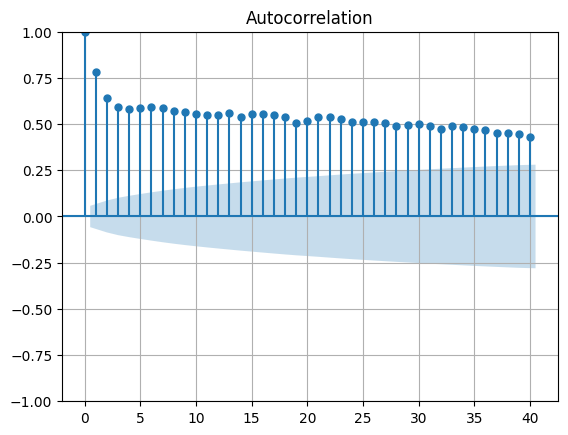

In [8]:
plot_acf(df, lags=40)
plt.grid(True)
plt.show()

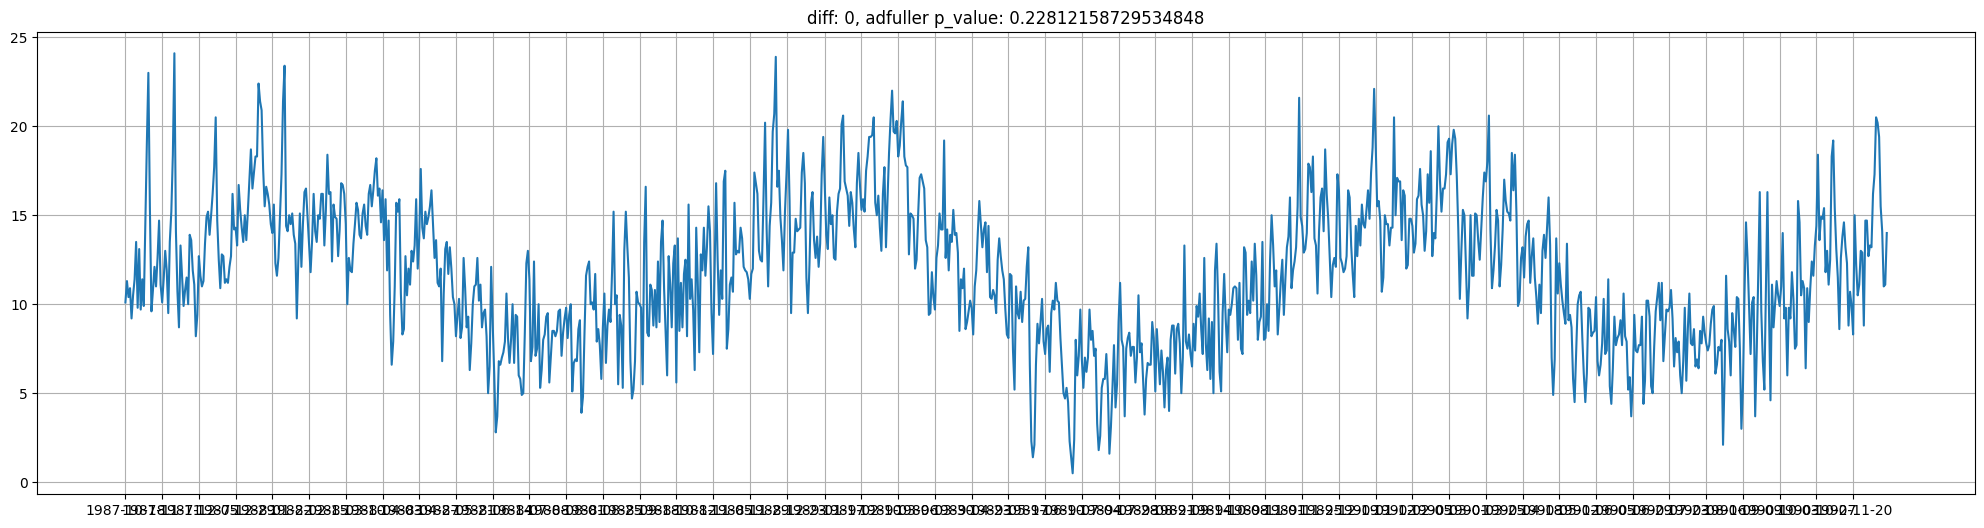

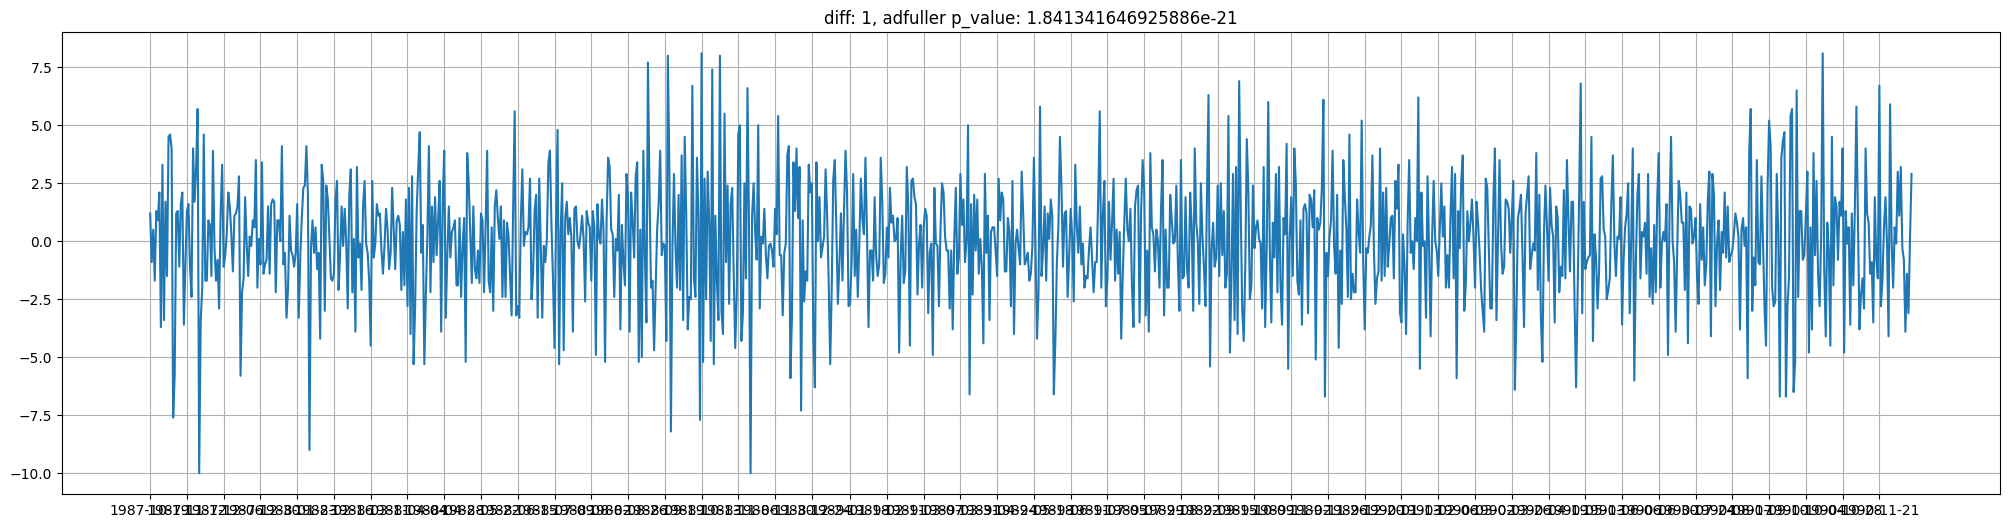

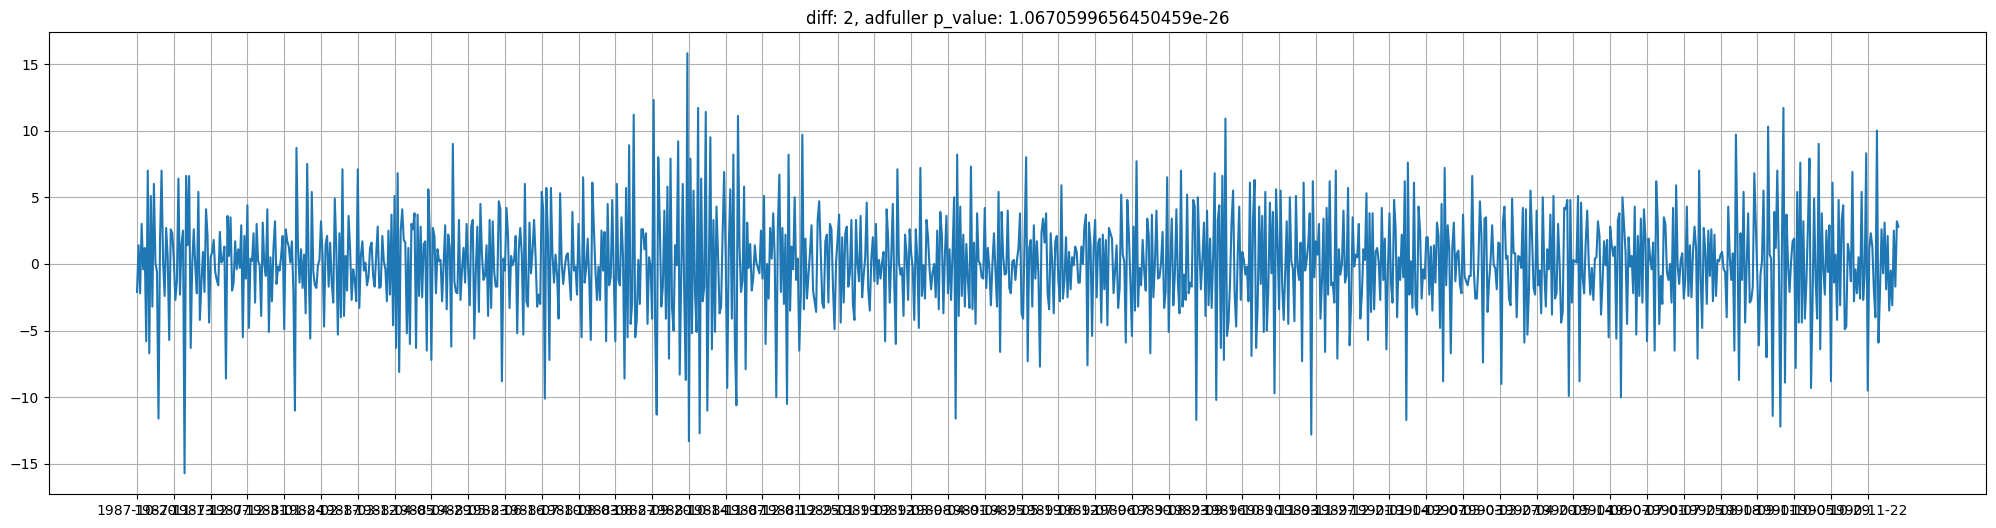

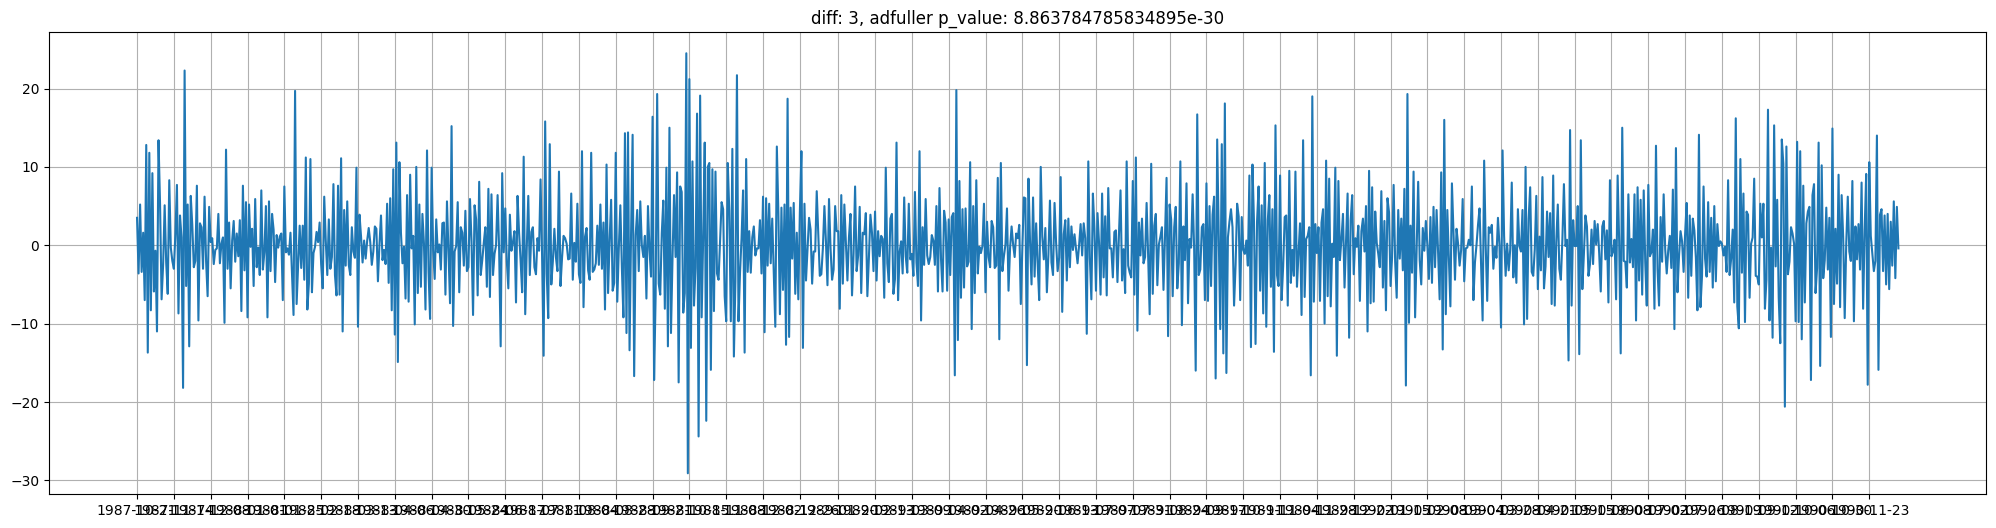

In [9]:
prev_diff = diff = df

plt.figure(figsize=(25, 6))
plt.plot(diff['temp'])
plt.xticks([diff.index[i] for i in range(0, len(diff), 24)])
plt.title(f'diff: 0, adfuller p_value: {adfuller(diff)[1]}')  # проверяем стационарность тестом Дики-Фуллера
plt.grid(True)
plt.show()

# построим разности вплоть до 3-го порядка для проверки

for i in range(3):
    prev_diff = diff
    diff = prev_diff - prev_diff.shift(1)
    diff = diff.dropna()
    plt.figure(figsize=(25, 6))
    plt.plot(diff['temp'])
    plt.xticks([diff.index[i] for i in range(0, len(diff), 24)])
    plt.title(f'diff: {i + 1}, adfuller p_value: {adfuller(diff)[1]}')
    plt.grid(True)
    plt.show()

In [10]:
model = SARIMAX(
    df['temp'], 
    order=(1, 1, 1),  # p, d, q
    seasonal_order=(1, 1, 1, 12)  # P, D, Q, s
).fit(disp=False)

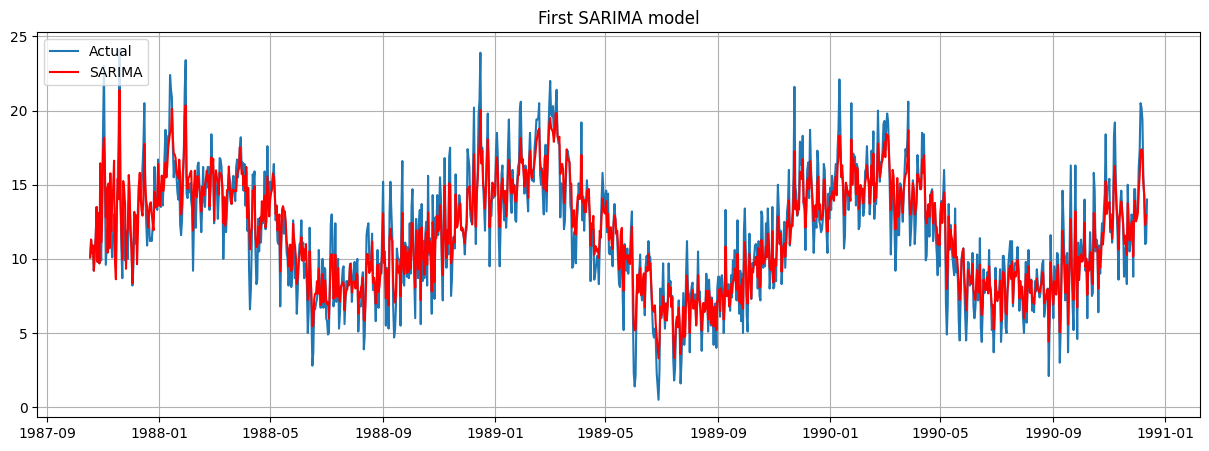

In [11]:
df['naive_sarima'] = model.fittedvalues.shift(-1)

plt.figure(figsize=(15, 5))
plt.title("First SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(df['naive_sarima'], "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

In [12]:
model.mae, model.mse

(1.8993633642981707, 5.908542277381876)

In [13]:
from itertools import product

ps = [1, 2, 3]
ds = [1]
qs = [1, 2, 3]
Ps = [1, 2, 3]
Ds = [1]
Qs = [1, 2, 3]
ss = [12]

parameters_list = list(product(ps, ds, qs, Ps, Ds, Qs, ss))
print(f'Всего наборов параметров: {len(parameters_list)}')

Всего наборов параметров: 81


In [14]:
from tqdm import tqdm

results = pd.DataFrame(columns=['p', 'd', 'q', 'P', 'D', 'Q', 's', 'mae', 'mse', 'aic'])

best_aic = 100500
best_model = None

for params in tqdm(parameters_list):
    # с некоторыми параметрами модель может не сойтись
    try:
        model = SARIMAX(
            df['temp'], 
            order=params[:3],  # p, d, q
            seasonal_order=params[3:]  # P, D, Q, s
        ).fit(disp=False)
    except:
        continue

    # сохраним лучшую модель
    if model.aic < best_aic:
        best_aic = model.aic
        best_model = model
    
    current_res = pd.DataFrame({
        'p': [params[0]],
        'd': [params[1]],
        'q': [params[2]],
        'P': [params[3]],
        'D': [params[4]],
        'Q': [params[5]],
        's': [params[6]],
        'mae': [model.mae],
        'mse': [model.mse],
        'aic': [model.aic]
    })
    results = pd.concat([results, current_res])

100%|██████████| 81/81 [20:58<00:00, 15.54s/it]


In [15]:
results = results.sort_values(by='aic')
results.head()

,p,d,q,P,D,Q,s,mae,mse,aic
0,2,1,1,2,1,3,12,1.880880,5.766752,5200.883151
0,2,1,1,3,1,3,12,1.881428,5.762663,5202.064068
0,3,1,1,2,1,3,12,1.880683,5.764535,5202.704894
0,1,1,2,2,1,3,12,1.883268,5.781136,5203.415003
0,2,1,1,1,1,1,12,1.887882,5.806323,5203.612351


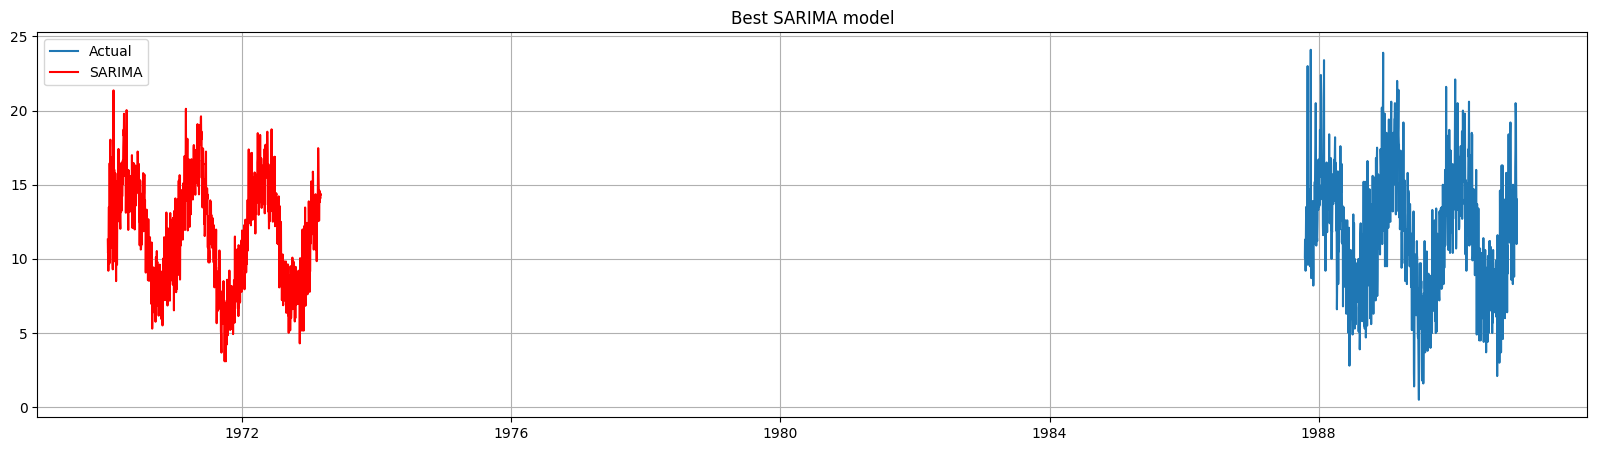

In [19]:
prediction_period = 7  # длина периода в днях

predicted = best_model.predict(1, end=len(df) + prediction_period).shift(-1)

plt.figure(figsize=(20, 5))
plt.title("Best SARIMA model")
plt.plot(df['temp'], label="Actual")
plt.plot(predicted, "r", label="SARIMA")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()

Генерация фич и предсказание бустингом

In [21]:
df_features = df.drop(columns=['naive_sarima']).copy()

for lag in range(1, 8, 1):
    df_features[f'lag_{lag}'] = df_features['temp'].shift(lag)

In [22]:
df_features.tail(12)

,temp,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7
date,,,,,,,,
1990-12-01,13.3,12.7,14.7,14.7,8.8,12.9,13.0,11.1
1990-12-02,13.2,13.3,12.7,14.7,14.7,8.8,12.9,13.0
1990-12-03,16.2,13.2,13.3,12.7,14.7,14.7,8.8,12.9
1990-12-04,17.3,16.2,13.2,13.3,12.7,14.7,14.7,8.8
1990-12-05,20.5,17.3,16.2,13.2,13.3,12.7,14.7,14.7
1990-12-06,20.2,20.5,17.3,16.2,13.2,13.3,12.7,14.7
1990-12-07,19.4,20.2,20.5,17.3,16.2,13.2,13.3,12.7
1990-12-08,15.5,19.4,20.2,20.5,17.3,16.2,13.2,13.3
1990-12-09,14.1,15.5,19.4,20.2,20.5,17.3,16.2,13.2


In [23]:
from math import sin, cos, pi

df_features['dayofyear'] = [date.dayofyear for date in df.index]
df_features['date_sin'] = [sin(day * 2 * pi / 365) for day in df_features['dayofyear']]
df_features['date_cos'] = [cos(day * 2 * pi / 365) for day in df_features['dayofyear']]

In [24]:
import numpy as np

df_features['mean_1_4'] = [df['temp'].iloc[i - 4:i - 1].mean() if i >= 4 else np.nan for i in range(len(df))]
df_features['mean_4_7'] = [df['temp'].iloc[i - 7:i - 1].mean() if i >= 7 else np.nan for i in range(len(df))]

df_features['min_1_4'] = [df['temp'].iloc[i - 4:i - 1].min() if i >= 4 else np.nan for i in range(len(df))]
df_features['min_4_7'] = [df['temp'].iloc[i - 7:i - 1].min() if i >= 7 else np.nan for i in range(len(df))]

df_features['max_1_4'] = [df['temp'].iloc[i - 4:i - 1].max() if i >= 4 else np.nan for i in range(len(df))]
df_features['max_4_7'] = [df['temp'].iloc[i - 7:i - 1].max() if i >= 7 else np.nan for i in range(len(df))]

df_features = df_features.dropna()

In [25]:
df_features.tail(12)

,temp,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,dayofyear,date_sin,date_cos,mean_1_4,mean_4_7,min_1_4,min_4_7,max_1_4,max_4_7
date,,,,,,,,,,,,,,,,,
1990-12-01,13.3,12.7,14.7,14.7,8.8,12.9,13.0,11.1,335,-0.493776,0.869589,12.733333,12.533333,8.8,8.8,14.7,14.7
1990-12-02,13.2,13.3,12.7,14.7,14.7,8.8,12.9,13.0,336,-0.478734,0.877960,14.033333,12.800000,12.7,8.8,14.7,14.7
1990-12-03,16.2,13.2,13.3,12.7,14.7,14.7,8.8,12.9,337,-0.463550,0.886071,13.566667,12.850000,12.7,8.8,14.7,14.7
1990-12-04,17.3,16.2,13.2,13.3,12.7,14.7,14.7,8.8,338,-0.448229,0.893919,13.066667,12.900000,12.7,8.8,13.3,14.7
1990-12-05,20.5,17.3,16.2,13.2,13.3,12.7,14.7,14.7,339,-0.432776,0.901502,14.233333,14.133333,13.2,12.7,16.2,16.2
1990-12-06,20.2,20.5,17.3,16.2,13.2,13.3,12.7,14.7,340,-0.417194,0.908818,15.566667,14.566667,13.2,12.7,17.3,17.3
1990-12-07,19.4,20.2,20.5,17.3,16.2,13.2,13.3,12.7,341,-0.401488,0.915864,18.000000,15.533333,16.2,12.7,20.5,20.5
1990-12-08,15.5,19.4,20.2,20.5,17.3,16.2,13.2,13.3,342,-0.385663,0.922640,19.333333,16.783333,17.3,13.2,20.5,20.5
1990-12-09,14.1,15.5,19.4,20.2,20.5,17.3,16.2,13.2,343,-0.369725,0.929141,20.033333,17.800000,19.4,13.2,20.5,20.5


In [26]:
# составим датасеты фичей и таргета

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X = scaler.fit_transform(df_features.drop(columns=['temp']).to_numpy())  # не забываем о нормализации данных
Y = df_features['temp'].to_numpy()

In [27]:
from xgboost import XGBRegressor

xgb = XGBRegressor()
xgb.fit(X, Y)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [28]:
df_features['xgb_result'] = xgb.predict(X)

In [29]:
df_features[['temp', 'xgb_result']]

,temp,xgb_result
date,,
1987-10-25,13.5,13.170741
1987-10-26,9.8,10.012910
1987-10-27,13.1,12.234655
1987-10-28,9.7,10.164371
1987-10-29,11.4,11.411182
...,...,...
1990-12-08,15.5,15.721927
1990-12-09,14.1,14.062534
1990-12-10,11.0,11.078897


In [32]:
additional_periods = 7

tmp_index = df_features.index.tolist()
for i in range(additional_periods):
    tmp_index.append(tmp_index[-1] + pd.DateOffset(months=1))

extended_df = pd.DataFrame(index=tmp_index)

extended_df['temp'] = df_features['temp'].tolist() + [np.nan] * additional_periods

# добавляем дополнительные лаги
for lag in range(1, 8, 1):
    extended_df[f'lag_{lag}'] = df_features[f'lag_{lag}'].tolist() + extended_df['temp'].shift(lag).tolist()[-additional_periods:]

# временнЫе фичи

extended_df['dayofyear'] = [date.dayofyear for date in extended_df.index]

extended_df['date_sin'] = [sin(date.day * 2*pi / 12) for date in extended_df.index]
extended_df['date_cos'] = [cos(date.day * 2*pi / 12) for date in extended_df.index]

# оконные статистики
extended_df['mean_1_4'] = df_features['mean_1_4'].tolist() + [extended_df['temp'].iloc[i - 4:i - 1].mean() for i in range(len(df_features), len(extended_df), 1)]
extended_df['mean_4_7'] = df_features['mean_4_7'].tolist() + [extended_df['temp'].iloc[i - 7:i - 4].mean() for i in range(len(df_features), len(extended_df), 1)]

extended_df['min_1_4'] = df_features['min_1_4'].tolist() + [extended_df['temp'].iloc[i - 4:i - 1].min() for i in range(len(df_features), len(extended_df), 1)]
extended_df['min_4_7'] = df_features['min_4_7'].tolist() + [extended_df['temp'].iloc[i - 7:i - 4].min() for i in range(len(df_features), len(extended_df), 1)]

extended_df['max_1_4'] = df_features['max_1_4'].tolist() + [extended_df['temp'].iloc[i - 4:i - 1].max() for i in range(len(df_features), len(extended_df), 1)]
extended_df['max_4_7'] = df_features['max_4_7'].tolist() + [extended_df['temp'].iloc[i - 7:i - 4].max() for i in range(len(df_features), len(extended_df), 1)]

In [33]:
X_extended = scaler.fit_transform(extended_df.drop(columns=['temp']).to_numpy())

extended_df['xgb_result'] = xgb.predict(X_extended)

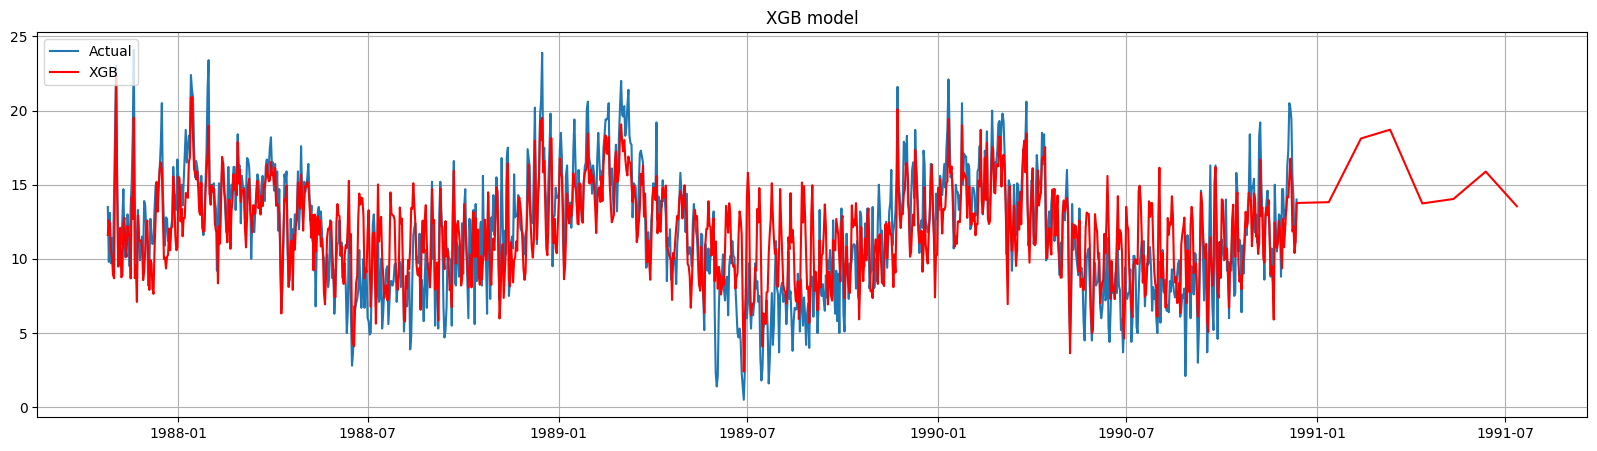

In [34]:
plt.figure(figsize=(20, 5))
plt.title("XGB model")
plt.plot(extended_df['temp'], label="Actual")
plt.plot(extended_df['xgb_result'], "r", label="XGB")
plt.legend(loc="upper left")
plt.grid(True)
plt.show()